# 

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import bz2
import csv
import re


In [42]:
# Load a subset of the training data
with bz2.BZ2File("/kaggle/input/d/bittlingmayer/amazonreviews/train.ft.txt.bz2") as f:
    training_data = [f.readline().decode('utf-8').strip() for _ in range(12000)]

# Load a subset of the training data
with bz2.BZ2File("/kaggle/input/d/bittlingmayer/amazonreviews/test.ft.txt.bz2") as f:
    test_data = [f.readline().decode('utf-8').strip() for _ in range(2500)]

# Print the subset sizes
print("Training data subset size:", len(training_data))
print("Test data subset size:", len(test_data))

Training data subset size: 12000
Test data subset size: 2500


In [43]:
training_data[0:5]

['__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 '__label__2 Amazing!: This sound

In [44]:
training_labels= [int(re.findall(r'__label__(\d)',line)[0]) for line in training_data]
training_texts = [re.sub(r'__label__\d ', '', line) for line in training_data]

test_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in test_data]
test_texts = [re.sub(r'__label__\d ', '', line) for line in test_data]

training_labels= [0 if label==1 else 1 for label in training_labels]
test_labels= [0 if label==1 else 1 for label in test_labels]


In [45]:
print(test_labels[:4])
print("\n\n", test_texts[:4])


[1, 1, 0, 1]


 ['Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"', "One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of t

1------> Positive
0-------> Negative

In [24]:
#Cleaning Text
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
def clean_text(text):
    """Cleans text by lowercasing, removing stopwords, and applying stemming."""
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters (keep spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize and remove stopwords, apply stemming
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]
    
    # Join words back into a string
    return " ".join(words)

# Apply function to training and test texts
training_texts = [clean_text(text) for text in training_texts]
test_texts = [clean_text(text) for text in test_texts]


In [30]:
test_texts[0]

'great cd love pat one great voic gener listen cd year still love im good mood make feel better bad mood evapor like sugar rain cd ooz life vocal jusat stuun lyric kill one life hidden gem desert isl cd book never made big beyond everytim play matter black white young old male femal everybodi say one thing sing'

In [31]:
# Tokenization and padding
max_words = 1000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(training_texts)

X_train = tokenizer.texts_to_sequences(training_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [32]:
X_train[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  19,  95, 195, 194, 978, 319,  21,  10,  19,
         59, 403,  73,  56,  66,  73,  73,  49,  66,  27,  56,  48, 176,
         69, 806, 954, 869,  10, 439, 120, 261, 152],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  27, 738,  49,
        209,  36,   3,  85,  44,  46,  27,  73, 738, 379, 359, 127,  4

In [33]:
X_train = np.array(X_train)
print(X_train.shape)
X_test = np.array(X_test)
print(X_test.shape)
y_train = np.array(training_labels)
print(y_train.shape)
y_test = np.array(test_labels)
print(y_test.shape)

(12000, 100)
(2500, 100)
(12000,)
(2500,)


In [38]:
# Define improved RNN model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    SimpleRNN(128, return_sequences=True, dropout=0.3),  # RNN layer with dropout
    LayerNormalization(),  # Added normalization for stability
    SimpleRNN(128, dropout=0.3),  # Second RNN layer
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 724ms/step - accuracy: 0.4917 - loss: 0.8636 - val_accuracy: 0.4916 - val_loss: 0.7405
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 664ms/step - accuracy: 0.5090 - loss: 0.7870 - val_accuracy: 0.5036 - val_loss: 0.7057
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 703ms/step - accuracy: 0.5022 - loss: 0.7668 - val_accuracy: 0.5200 - val_loss: 0.6970
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 676ms/step - accuracy: 0.5064 - loss: 0.7537 - val_accuracy: 0.5320 - val_loss: 0.6897
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 686ms/step - accuracy: 0.5060 - loss: 0.7404 - val_accuracy: 0.5256 - val_loss: 0.6929
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 669ms/step - accuracy: 0.5118 - loss: 0.7348 - val_accuracy: 0.5396 - val_loss: 0.6870
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 675ms/step - accuracy: 0.5176 - loss: 0.7284 - val_accuracy: 0.5424 - val_loss: 0.6887
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 667ms/step - accuracy: 0.5178 - loss: 0.7225 - val_accu

Accuracy-----> 87.4%

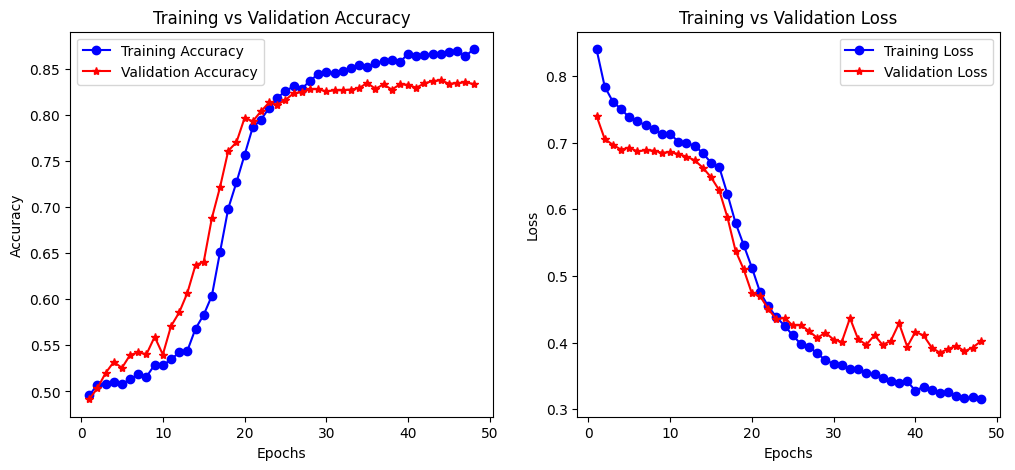

In [39]:
# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [47]:
# Evaluate with a confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Confusion Matrix:
[[ 957  234]
 [ 175 1134]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1191
           1       0.83      0.87      0.85      1309

    accuracy                           0.84      2500
   macro avg       0.84      0.83      0.84      2500
weighted avg       0.84      0.84      0.84      2500



In [49]:
# Training LSTM
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)),  
    LayerNormalization(),# Added normalization for stability
    Dropout(0.3),
    Bidirectional(LSTM(128, recurrent_dropout=0.2)),  
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.5138 - loss: 0.8419 - val_accuracy: 0.6000 - val_loss: 0.6633
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.5608 - loss: 0.7068 - val_accuracy: 0.6280 - val_loss: 0.6537
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.5996 - loss: 0.6649 - val_accuracy: 0.6708 - val_loss: 0.6264
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.6407 - loss: 0.6268 - val_accuracy: 0.7196 - val_loss: 0.5640
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.6945 - loss: 0.5755 - val_accuracy: 0.7572 - val_loss: 0.5077
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.7412 - loss: 0.5156 - val_accuracy: 0.7772 - val_loss: 0.4737
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.7812 - loss: 0.4711 - val_accuracy: 0.7904 - val_loss: 0.4486
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.7956 - loss: 0.4476 - val_accuracy: 0.8048 - val_loss

Accuracy-------> 87.6%


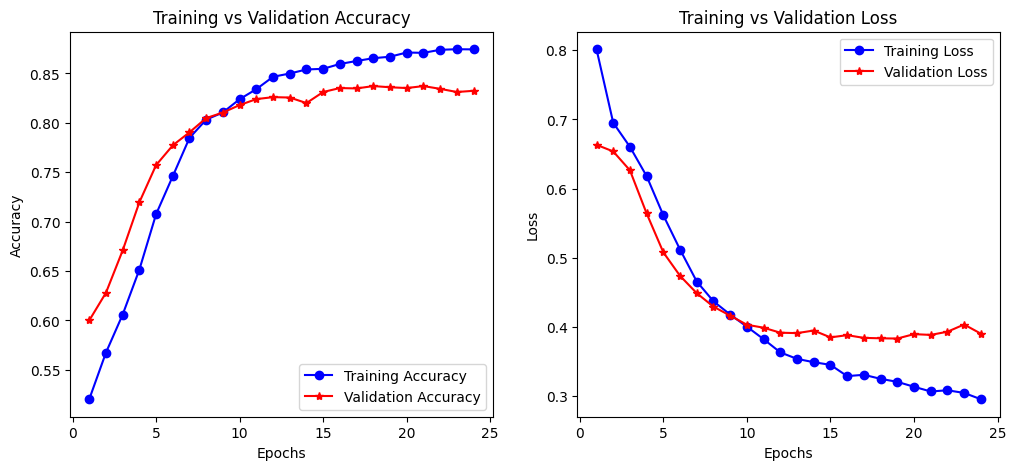

In [50]:
# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [51]:
# Evaluate with a confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step
Confusion Matrix:
[[ 953  238]
 [ 172 1137]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1191
           1       0.83      0.87      0.85      1309

    accuracy                           0.84      2500
   macro avg       0.84      0.83      0.84      2500
weighted avg       0.84      0.84      0.84      2500



In [52]:
# Training GRU
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),  # GRU layer with dropout
    LayerNormalization(),  # Added normalization for stability
    GRU(128, dropout=0.3, recurrent_dropout=0.2),  # Second GRU layer
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5064 - loss: 0.8651 - val_accuracy: 0.5580 - val_loss: 0.7121
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5370 - loss: 0.7942 - val_accuracy: 0.5828 - val_loss: 0.6769
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5495 - loss: 0.7643 - val_accuracy: 0.6044 - val_loss: 0.6550
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5805 - loss: 0.7223 - val_accuracy: 0.6236 - val_loss: 0.6395
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5873 - loss: 0.7121 - val_accuracy: 0.6372 - val_loss: 0.6278
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5968 - loss: 0.6989 - val_accuracy: 0.6436 - val_loss: 0.6181
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6129 - loss: 0.6675 - val_accuracy: 0.6564 - val_loss: 0.6080
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6199 - loss: 0.6754 - val_accuracy: 0.6708 - val_loss: 0.5987
Epo

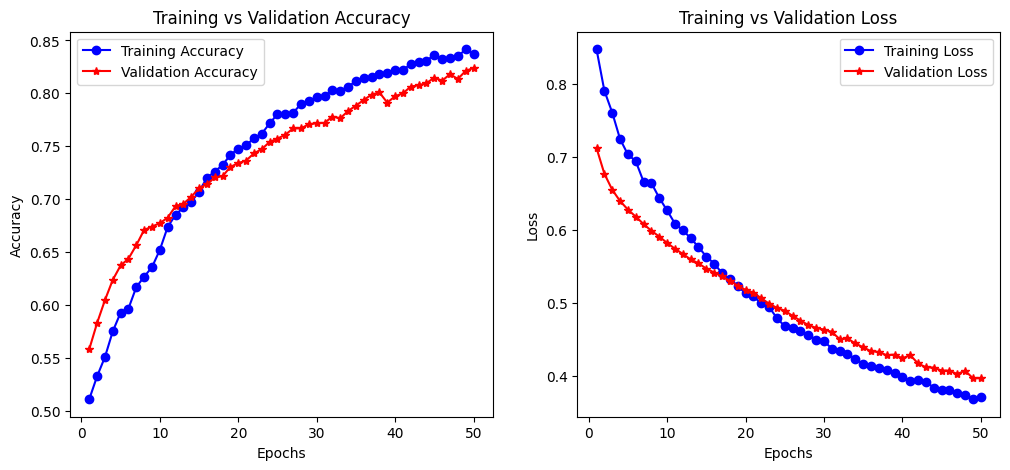

In [53]:
# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [54]:
# Evaluate with a confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step
Confusion Matrix:
[[ 969  222]
 [ 225 1084]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1191
           1       0.83      0.83      0.83      1309

    accuracy                           0.82      2500
   macro avg       0.82      0.82      0.82      2500
weighted avg       0.82      0.82      0.82      2500



In [57]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentiment(text, model, tokenizer, max_sequence_length=100):
    # clean text
    text = clean_text(text)
    # Convert text to sequence
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    # Predict sentiment
    prediction = model.predict(padded_sequence)[0][0]  # Extract scalar value
    
    # Determine sentiment
    sentiment = "Positive 😊" if prediction > 0.5 else "Negative 😡"
    
    return sentiment, float(prediction)

# Example usage:
test_sentences = [
    "I love this product! It's amazing.",
    "This is the worst service I have ever experienced.",
    "The movie was okay, not great but not terrible either."
]

for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(sentence, model, tokenizer)
    print(f"Text: {sentence}\nPredicted Sentiment: {sentiment} (Confidence: {confidence:.4f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Text: I love this product! It's amazing.
Predicted Sentiment: Positive 😊 (Confidence: 0.9781)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Text: This is the worst service I have ever experienced.
Predicted Sentiment: Negative 😡 (Confidence: 0.0095)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Text: The movie was okay, not great but not terrible either.
Predicted Sentiment: Negative 😡 (Confidence: 0.2729)



In [62]:
model.save("lstm_model.h5")

import pickle
with open("tokenizer.pkl","wb") as f:
    pickle.dump(tokenizer, f)

In [63]:
import tensorflow as tf
print(tf.__version__)

2.18.0
